<a href="https://colab.research.google.com/github/melvinebenezer/vlm/blob/main/triton_begin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!TORCH_LOGS="output_code"

In [7]:
!pip install triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 5.7 MB/s eta 0:00:00


In [2]:
import torch
def foo(x, y):
    a = torch.sin(x)
    b = torch.cos(y)
    return a + b
opt_foo1 = torch.compile(foo)
print(opt_foo1(torch.randn(10, 10), torch.randn(10, 10)))

tensor([[ 1.1643,  0.8201,  1.6931,  0.6981,  1.3494,  1.3233,  1.5315,  0.3036,
         -0.0810,  0.4657],
        [-0.4047,  1.1607,  1.0395,  0.5696,  0.1893,  0.4726,  1.2522,  1.2532,
          1.5451,  0.5413],
        [ 1.1670,  1.7914, -0.1941,  1.3411,  0.9847, -0.4338,  1.3037,  0.4099,
          1.2998,  0.1000],
        [-0.1611,  1.0597,  1.8361,  1.0590,  1.8402,  0.0303,  1.8497,  0.0300,
          1.4823,  1.2299],
        [ 0.3434,  1.5049,  0.5931,  0.0273,  1.9042,  0.3817,  1.8397,  0.0181,
          1.8198,  0.2128],
        [-0.1869, -0.3727,  1.0029,  0.5503,  1.6211,  1.8558,  0.6798,  0.1130,
         -0.5161,  1.5479],
        [ 0.3906,  1.5585, -1.3242,  1.8108,  0.2839,  0.2651,  0.1353,  0.3905,
          0.8233,  0.4897],
        [ 1.2215,  0.1788,  1.7526,  1.8165, -0.8574, -0.3171,  1.2642,  0.3282,
          0.8711, -0.2298],
        [ 0.9723,  1.6085,  1.1266, -0.4956, -0.8927,  0.2833,  1.4792,  1.5475,
         -0.4174,  0.1177],
        [ 0.1929, -

In [8]:
! TORCH_LOGS="output_code" python pytorch_compile.py

V1008 05:40:53.422000 139309300236288 torch/_inductor/graph.py:1683] [0/0] [__output_code] Output code: 
V1008 05:40:53.422000 139309300236288 torch/_inductor/graph.py:1683] [0/0] [__output_code] 
V1008 05:40:53.422000 139309300236288 torch/_inductor/graph.py:1683] [0/0] [__output_code] # AOT ID: ['0_inference']
V1008 05:40:53.422000 139309300236288 torch/_inductor/graph.py:1683] [0/0] [__output_code] from ctypes import c_void_p, c_long
V1008 05:40:53.422000 139309300236288 torch/_inductor/graph.py:1683] [0/0] [__output_code] import torch
V1008 05:40:53.422000 139309300236288 torch/_inductor/graph.py:1683] [0/0] [__output_code] import math
V1008 05:40:53.422000 139309300236288 torch/_inductor/graph.py:1683] [0/0] [__output_code] import random
V1008 05:40:53.422000 139309300236288 torch/_inductor/graph.py:1683] [0/0] [__output_code] import os
V1008 05:40:53.422000 139309300236288 torch/_inductor/graph.py:1683] [0/0] [__output_code] import tempfile
V1008 05:40:53.422000 139309300236288 t

In [4]:
! cp /tmp/torchinductor_root/7x/c7xpa3psgauuqodow6bjeamuoehks4ga7wq26zqoyezaxm7fpyrf.py pc_triton.py

In [12]:
import torch

import triton
import triton.language as tl
from triton.runtime import driver


def is_hip():
    return triton.runtime.driver.active.get_current_target().backend == "hip"


def is_cdna():
    return is_hip() and triton.runtime.driver.active.get_current_target().arch in ('gfx940', 'gfx941', 'gfx942',
                                                                                   'gfx90a', 'gfx908')


def naive_softmax(x):
    """Compute row-wise softmax of X using native pytorch

    We subtract the maximum element in order to avoid overflows. Softmax is invariant to
    this shift.
    """
    # read  MN elements ; write M  elements
    x_max = x.max(dim=1)[0]
    # read MN + M elements ; write MN elements
    z = x - x_max[:, None]
    # read  MN elements ; write MN elements
    numerator = torch.exp(z)
    # read  MN elements ; write M  elements
    denominator = numerator.sum(dim=1)
    # read MN + M elements ; write MN elements
    ret = numerator / denominator[:, None]
    # in total: read 5MN + 2M elements ; wrote 3MN + 2M elements
    return ret

@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols, BLOCK_SIZE: tl.constexpr,
                   num_stages: tl.constexpr):
    # starting row of the program
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
        # The stride represents how much we need to increase the pointer to advance 1 row
        row_start_ptr = input_ptr + row_idx * input_row_stride
        # The block size is the next power of two greater than n_cols, so we can fit each
        # row in a single block
        col_offsets = tl.arange(0, BLOCK_SIZE)
        input_ptrs = row_start_ptr + col_offsets
        # Load the row into SRAM, using a mask since BLOCK_SIZE may be > than n_cols
        mask = col_offsets < n_cols
        row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
        # Subtract maximum for numerical stability
        row_minus_max = row - tl.max(row, axis=0)
        # Note that exponentiation in Triton is fast but approximate (i.e., think __expf in CUDA)
        numerator = tl.exp(row_minus_max)
        denominator = tl.sum(numerator, axis=0)
        softmax_output = numerator / denominator
        # Write back output to DRAM
        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        output_ptrs = output_row_start_ptr + col_offsets
        tl.store(output_ptrs, softmax_output, mask=mask)

device = torch.cuda.current_device()
properties = driver.active.utils.get_device_properties(device)
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}


def softmax(x):
    n_rows, n_cols = x.shape

    # The block size of each loop iteration is the smallest power of two greater than the number of columns in `x`
    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    # Another trick we can use is to ask the compiler to use more threads per row by
    # increasing the number of warps (`num_warps`) over which each row is distributed.
    # You will see in the next tutorial how to auto-tune this value in a more natural
    # way so you don't have to come up with manual heuristics yourself.
    num_warps = 8

    # Number of software piepling stages.
    num_stages = 4 if SIZE_SMEM > 200000 else 2

    # Allocate output
    y = torch.empty_like(x)

    # pre-compile kernel to get register usage and compute thread occupancy.
    kernel, num_programs = kernels.get(BLOCK_SIZE, (None, 0))
    if kernel is None:
        kernel = softmax_kernel.warmup(y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                       num_stages=num_stages, num_warps=num_warps, grid=(1, ))
        kernel._init_handles()
        n_regs = kernel.n_regs
        size_smem = kernel.metadata.shared
        if is_hip():
            # NUM_REGS represents the number of regular purpose registers. On CDNA architectures this is half of all registers available.
            # However, this is not always the case. In most cases all registers can be used as regular purpose registers.
            # ISA SECTION (3.6.4 for CDNA3)
            # VGPRs are allocated out of two pools: regular VGPRs and accumulation VGPRs. Accumulation VGPRs are used
            # with matrix VALU instructions, and can also be loaded directly from memory. A wave may have up to 512 total
            # VGPRs, 256 of each type. When a wave has fewer than 512 total VGPRs, the number of each type is flexible - it is
            # not required to be equal numbers of both types.
            if is_cdna():
                NUM_GPRS = NUM_REGS * 2

            # MAX_NUM_THREADS represents maximum number of resident threads per multi-processor.
            # When we divide this number with WARP_SIZE we get maximum number of waves that can
            # execute on a CU (multi-processor)  in parallel.
            MAX_NUM_THREADS = properties["max_threads_per_sm"]
            max_num_waves = MAX_NUM_THREADS // WARP_SIZE
            occupancy = min(NUM_GPRS // WARP_SIZE // n_regs, max_num_waves) // num_warps
        else:
            occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
        occupancy = min(occupancy, SIZE_SMEM // size_smem)
        num_programs = NUM_SM * occupancy
        kernels[BLOCK_SIZE] = (kernel, num_programs)

    num_programs = min(num_programs, n_rows)

    # Create a number of persistent programs.
    kernel[(num_programs, 1, 1)](
        y,
        x,
        x.stride(0),
        y.stride(0),
        n_rows,
        n_cols,
    )
    return y

In [13]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device='cuda')
y_triton = softmax(x)
y_torch = torch.softmax(x, axis=1)
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


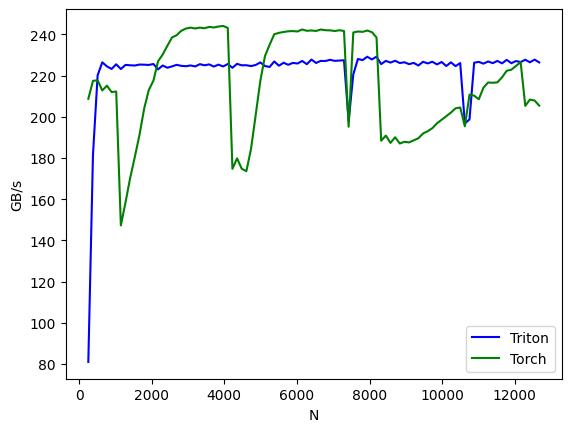

softmax-performance:
          N      Triton       Torch
0     256.0   80.933930  208.736299
1     384.0  181.460313  217.479720
2     512.0  220.163899  217.733959
3     640.0  226.463121  212.802535
4     768.0  224.515714  215.138068
5     896.0  223.253723  212.019552
6    1024.0  225.512951  212.291189
7    1152.0  223.208426  147.250800
8    1280.0  225.212610  158.434245
9    1408.0  225.031559  170.299687
10   1536.0  224.913773  180.484605
11   1664.0  225.381105  191.117663
12   1792.0  225.316459  203.840386
13   1920.0  225.194946  212.975132
14   2048.0  225.656387  217.541806
15   2176.0  223.046731  226.971163
16   2304.0  224.927143  230.259297
17   2432.0  223.847415  234.494477
18   2560.0  224.492621  238.541209
19   2688.0  225.248405  239.649187
20   2816.0  224.760439  241.800882
21   2944.0  224.589876  242.872887
22   3072.0  224.941633  243.327018
23   3200.0  224.472960  242.910287
24   3328.0  225.580390  243.321380
25   3456.0  225.016769  243.032493
26   35

In [14]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device='cuda', dtype=torch.float32)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)